# E-commerce — Выявление профилей потребления

__Задача:__

Сегментировать покупателей по профилю потребления для осуществления рекламных рассылок

__Описание проекта__

Интернет-магазин товаров для дома и быта  хочет сегментировать покупателей на группы, для более целевого осуществления рекламных рассылок. 

В пректе мы составим подробные рекомендации заказчику по сегментам покупателей:
В каком сегменте покупатели покупают часто, много и дорогой товар, а на какой сегмент, возможно, не стоит тратить время и деньги проводя рассылку.

Клиентам какого сегмента, когда и какие категории товара рассылать в рекламных предложениях.

Как для какого типа клиентов можно попытаться увеличить
количество продаваемого товара, повысить возвращаемость покупателей и т.д.

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from itertools import combinations


pd.set_option('display.max_rows', None)  # Показывать все строки
pd.set_option('display.max_columns', None)  # Показывать все столбцы


In [2]:
df = pd.read_csv(')
df.head(3)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


В анализируемой выборке содержится 7474 записей и 6 признаков, охватывающих информацию о транзакциях интернет-магазина товаров для дома. Признаки включают дату заказа, идентификатор покупателя, наименование товара, количество товара в заказе, цену товара.

Данные представлены в различных форматах: 1 признак имеет числовой тип float64, 2 — строковый тип objectб 3 - числовой тип данных int64. В выборке нет пропущенных значений. Общий объём занимаемой памяти составляет около 350.5 KB.

## Предобработка данных

### Тип данных

В таблице неправильно указан тип даттых с датой. Поменем его.

In [4]:
# преобразуем в строку
df['date'] = df['date'].astype(str)

In [5]:
# преобразуем в datetime по нужному формату
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df['date'].head(10)

0   2018-10-01 00:00:00
1   2018-10-01 00:00:00
2   2018-10-01 00:00:00
3   2018-10-01 00:00:00
4   2018-10-01 00:00:00
5   2018-10-01 00:00:00
6   2018-10-01 00:00:00
7   2018-10-01 08:00:00
8   2018-10-01 08:00:00
9   2018-10-01 09:00:00
Name: date, dtype: datetime64[ns]

### Пропуски

In [6]:
df.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Пропусков нет

### Дубликаты явные и не явные

In [7]:
#приведем данные в столбце product к нижнему регистру и заменим 'ё' на 'е'
df['product'] = df['product'].str.lower()
df['product'] = df['product'].str.replace('ё','е')

In [8]:
#посмотрим есть ли явные дубликаты
df.duplicated().sum()

0

Явных дубликатов нет.

Один и тотже клиент мог случайно оформить одинаковый заказ дважды в один день. Выявим таких клиентов:

In [9]:
#посмотрим есть ли не явные дубликаты по столбцам data, customer, product
df_2 = df[df.duplicated(subset=['date','customer_id','product'],keep=False)]


In [10]:
percent_d = df.duplicated(subset=['date','customer_id','product'],keep=False).mean() * 100
print(f'Дубликатов {percent_d:.2f}%')

Дубликатов 0.54%


Всего 0.5%,можем удалить их

In [11]:
#удалим строки с дубликатами, оставим первую:
df = df.drop_duplicates(subset=['date','customer_id','product'], keep='first')

Посмотрим есть ли полностью одинаковые заказы но с разным временем(датой). Это может быть потому что во время заказа система дважды продублировала запись

In [12]:
#посмотрим есть ли не явные дубликаты по всем столбцам кроме даты
df_3 = df[df.duplicated(subset=['customer_id', 'order_id', 'product','quantity','price'],keep=False)]

In [13]:
percent_dup = df.duplicated(subset=['customer_id', 'order_id', 'product','quantity','price'],keep=False).mean() * 100
print(f'Дубликатов {percent_dup:.2f}%')

Дубликатов 31.78%


В данных много строк в которых совпадают номера заказов и номер клиента, но с разным временем заказа. Таких строк достаточно много - 31%. Удалим их, они скорее всего ошибочно попали в таблицу, дублируют один и тот же заказ. 

In [14]:
#удалим строки с дубликатами, оставим первую:
df = df.drop_duplicates(subset=['customer_id', 'order_id', 'product','quantity','price'], keep='first')


Посмотрим есть ли полностью одинаковые заказы совершенные более чем одним покупателем. 


In [15]:
#посмотрим есть ли не явные дубликаты по столбцам order_id,product,quantity,price
df_4 = df[df.duplicated(subset=['order_id','product','quantity','price'],keep=False)]

In [16]:
percent = df.duplicated(subset=['order_id','product','quantity','price'],keep=False).mean() * 100
print(f'Дубликатов {percent:.2f}%')

Дубликатов 1.13%


Совсем не много, 1.13%, смело удаляем их.

In [17]:
#удалим строки с дубликатами, оставим первую:
df = df.drop_duplicates(subset=['order_id','product','quantity','price'], keep='first')


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5557 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5557 non-null   datetime64[ns]
 1   customer_id  5557 non-null   object        
 2   order_id     5557 non-null   int64         
 3   product      5557 non-null   object        
 4   quantity     5557 non-null   int64         
 5   price        5557 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 303.9+ KB


В данных осталось 5557 строк

### Посмотрим за какой период представленны данные. Сделать отдельный столбец с датой: месяц и год покупки

In [19]:
min_date = df['date'].min()
max_date = df['date'].max()

print('Данные представленны за период с', min_date, 'по', max_date)

Данные представленны за период с 2018-10-01 00:00:00 по 2020-01-31 15:00:00


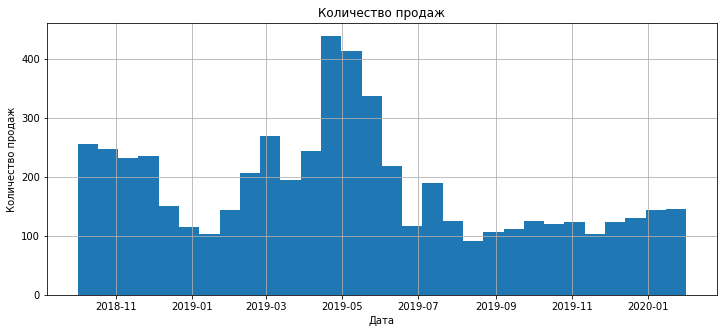

In [20]:
# посмотрим количество продаж за период времени на графике
df['date'].hist(bins=30, grid=True, figsize=(12,5))
plt.title('Количество продаж')
plt.xlabel('Дата')
plt.ylabel('Количество продаж')

plt.show()

На графике видно что большинство продаж было в период апрель-июнь 2019 года

In [21]:
df['date_new'] = df['date'].dt.to_period('M').astype(str)
df.head(3)

,date,customer_id,order_id,product,quantity,price,date_new
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10


Данные представлены с 1 октября 2018 по 31 января 2020. Большинство продаж было в период апрель-июнь. Добывили в таблицу столбец с месяцем и годом.

### Добавим столбец - чек покупки. Он понадобится нам после для анализа.

In [22]:
# сначала добавим в основную таблицу столбец где мы посчитаем чек по каждому заказу
df['total_price'] = df['quantity']*df['price']

## Исследовательский анализ данных

### Проверим какие значения встречаются в столбцах с целыми и вещественными числами. Изучим средние значения и стандартные отклонения


__Посмотрим какие значения встречаются в столбце с ценой.__ 

In [23]:
df['price'].describe()

count     5557.000000
mean       529.195984
std        972.126398
min          9.000000
25%         90.000000
50%        150.000000
75%        524.000000
max      14917.000000
Name: price, dtype: float64

Большая разница между средней и медианой, что говорит нам о большом разбросе цен. Минимальная цена 9 руб, а максимальная 14917

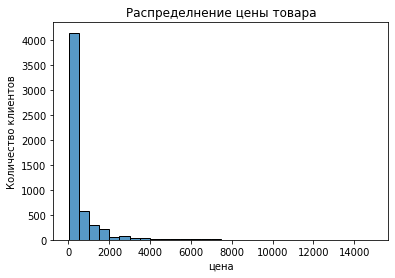

In [24]:
sns.histplot(df['price'],bins=30)
plt.title('Распределнение цены товара')
plt.xlabel('цена')
plt.ylabel('Количество клиентов')
plt.show()

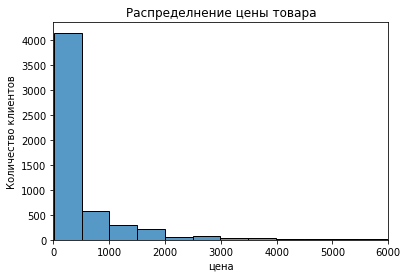

In [25]:
# посмотрим полее детально, отбросим хвост
sns.histplot(df['price'],bins=30)
plt.xlim(0,6000)
plt.title('Распределнение цены товара')
plt.xlabel('цена')
plt.ylabel('Количество клиентов')
plt.show()

На графике видно что большинство товаров по цена до 500 рублей 

In [26]:
# посмотрим какие товары стоят дороже 6000
large_price = df[df['price'] > 6000]

Высокую цену имеют все товары из категории товары для дома и быта. 

__Посмотрим какие значения встречаются в столбце с количеством товара.__ 

In [27]:
df['quantity'].value_counts().sort_index()

1       4442
2        510
3        138
4        101
5         67
6         41
7         21
8         13
9          7
10        69
11         5
12        13
13         5
14         2
15        22
16         4
17         1
18         1
20        16
22         1
23         1
24         3
25        16
26         1
27         2
29         1
30        16
31         1
37         1
40         3
43         1
45         1
50         8
57         1
59         1
60         2
64         2
65         1
70         1
80         1
96         1
100        4
140        1
150        3
170        1
200        1
300        1
334        1
1000       1
Name: quantity, dtype: int64

In [28]:
df['quantity'].describe()

count    5557.000000
mean        2.585748
std        16.468791
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

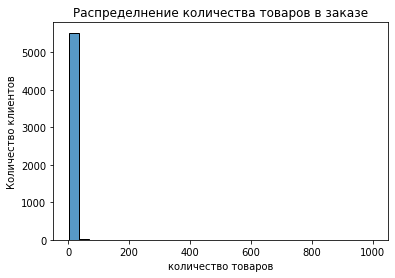

In [29]:
sns.histplot(df['quantity'],bins=30)
plt.title('Распределнение количества товаров в заказе')
plt.xlabel('количество товаров')
plt.ylabel('Количество клиентов')
plt.show()

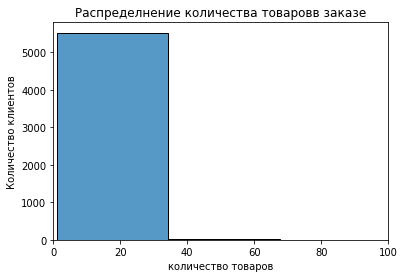

In [30]:
# посмотрим полее детально, отбросим хвост
sns.histplot(df['quantity'],bins=30)
plt.xlim(0,100)
plt.title('Распределнение количества товаровв заказе')
plt.xlabel('количество товаров')
plt.ylabel('Количество клиентов')
plt.show()

В основном покупают один товар. НО были товары, которых купили 1000, 334, 300 b 200 штук. Эти и объясняется разница между средним и медианным значением и то что стандартное отклонение равно 16. Посмотрим что это за товары, которые купили в таком количестве. 

In [31]:
large_orders = df[df['quantity'] > 100]
large_orders.head(3)

,date,customer_id,order_id,product,quantity,price,date_new,total_price
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19.0,2018-10,2850.0
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38.0,2018-10,5700.0
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0,2018-11,8670.0


Найдем клиентов с аномально большими заказами и посмотрим все заказы этих клиентов

In [32]:
# найдем клиентов с аномально большими заказами
anomaly_clients = df[df['quantity'] > 100]['customer_id'].unique()
anomaly_clients

array(['cd09ea73-d9ce-48c3-b4c5-018113735e80',
       'aa42dc38-780f-4b50-9a65-83b6fa64e766',
       '0c5aaa88-e346-4f87-8f7a-ad8cbc04e965',
       'a984c5b7-ff7e-4647-b84e-ef0b85a2762d',
       '685d3d84-aebb-485b-8e59-344b3df8b3d3',
       '5d189e88-d4d6-4eac-ab43-fa65a3c4d106',
       '146cd9bf-a95c-4afb-915b-5f6684b17444',
       '312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6'], dtype=object)

In [33]:
# найдем все строки для этих клиентов
orders_anomaly_clients = df[df['customer_id'].isin(anomaly_clients)]
orders_anomaly_clients

,date,customer_id,order_id,product,quantity,price,date_new,total_price
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19.0,2018-10,2850.0
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38.0,2018-10,5700.0
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0,2018-11,8670.0
586,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,муляж яблоко 9 см красное,140,59.0,2018-11,8260.0
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"ручка-скоба рс-100 белая *трибатрон*, 1108035",200,29.0,2018-12,5800.0
2431,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,плечики пластмассовые размер 52 - 54 тула 1205158,150,20.0,2019-03,3000.0
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51.0,2019-05,15300.0
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,2019-06,49432.0
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,2019-06,675000.0


Из таблицы видно что у нескольких клиентов встречается заказ - муляж яблоко 9 см красное, заказали 170, 140, 300 штук. Возможно именно этот товар часто покупают оптом, скорее всего его используют для витрин и декора.

Крепеж для пружины и пружина деревянная - по 150 штук. Заказал один клиент, вероятно это оптовая закупка, используется в массовом производстве. Тоже самое ручка-скоба - 200 штук.

Плечики и вешалки - могут быть тоже оптовой закупкой, 150 и 334 штуки. 

Вантусы - 1000 штук. Возможно это самый странный заказ. И самый большой. 
Удалим эту позицию, она сильно искажает анализ среднего количества товаров. 

In [34]:
# удалим строчку с заказом вантуза на 1000 штук
df = df[~(df['quantity']==1000)]

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5556 entries, 0 to 7473
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5556 non-null   datetime64[ns]
 1   customer_id  5556 non-null   object        
 2   order_id     5556 non-null   int64         
 3   product      5556 non-null   object        
 4   quantity     5556 non-null   int64         
 5   price        5556 non-null   float64       
 6   date_new     5556 non-null   object        
 7   total_price  5556 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 390.7+ KB


### Есть ли покупатели, которые чаще всех заказывают товары, определим этих покупателей. Есть ли покупатели оптовики которые заказывают больше всего. 


__Покупатели-оптовики:__

In [36]:
# посмотрим на покупателей-оптовиков, которые заказали больше всего товаров за раз
large_quantity = df[df['quantity'] >= 50]


In [37]:
large_quantity['customer_id'].nunique()

27

In [38]:
# найдем клиентов оптовиков
wholesale_clients = df[df['quantity'] >= 50]['customer_id'].unique()
wholesale_clients

array(['0948b0c2-990b-4a11-b835-69ac4714b21d',
       'c971fb21-d54c-4134-938f-16b62ee86d3b',
       'cd09ea73-d9ce-48c3-b4c5-018113735e80',
       '4d93d3f6-8b24-403b-a74b-f5173e40d7db',
       'aa42dc38-780f-4b50-9a65-83b6fa64e766',
       '0c5aaa88-e346-4f87-8f7a-ad8cbc04e965',
       '8fba3604-ef57-4b9f-b2fe-3402fa8825c8',
       '7d255526-fcc2-4f79-b28a-217d7d2373a8',
       'a984c5b7-ff7e-4647-b84e-ef0b85a2762d',
       '6987e6d6-a63a-4ce2-a2d0-f424092d235e',
       '34b2bf7d-7cd8-4aba-909d-396655d77f7e',
       '8eabcaca-e8c8-4eee-9079-4ff5f612273a',
       '74b08ab4-16e9-4d83-9c31-acfc9d229bc5',
       '377c8a20-a3e0-4945-9fd8-a1f4ada5d8b0',
       '685d3d84-aebb-485b-8e59-344b3df8b3d3',
       'aaafc0ca-1fd4-4d0b-b7b8-37391c319fd3',
       '498f12a4-6a62-4725-8516-cf5dc9ab8a3a',
       '5d189e88-d4d6-4eac-ab43-fa65a3c4d106',
       'f9d19e1d-9414-485b-9d8d-02bc196a88e8',
       '146cd9bf-a95c-4afb-915b-5f6684b17444',
       'de95510f-3558-4c42-97dc-98cc4215c278',
       '0af07

In [39]:
# добавим столбец с пометкой, оптовик этот клиент или нет. 
df['is_wholesale'] = df['customer_id'].isin(wholesale_clients)

Всего выделили 21 клиента-оптовика. Сделали отдельный столбец с пометкой таких клиентов. Чаще всего они заказывают товары для быта и хозяйственные товары. 

__Покупатели, которые чаще всего делают заказы:__

In [40]:
# посмотрим на покупателей, которые чаще всего делают заказы
order_counts = df.groupby('customer_id')['order_id'].nunique()
order_counts.sort_values(ascending=False).head(5)

customer_id
c971fb21-d54c-4134-938f-16b62ee86d3b    126
4d93d3f6-8b24-403b-a74b-f5173e40d7db     35
73d1cd35-5e5f-4629-8cf2-3fda829d4e58     17
b7b865ab-0735-407f-8d0c-31f74d2806cc      7
0184f535-b60a-4914-a982-231e3f615206      5
Name: order_id, dtype: int64

Есть постоянный покупатель, который заказывал 126 раз. Посмотрим что:

In [41]:
df.query('customer_id =="c971fb21-d54c-4134-938f-16b62ee86d3b"').head(3)

,date,customer_id,order_id,product,quantity,price,date_new,total_price,is_wholesale
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,чехол для гладильной доски colombo persia beig...,1,674.0,2018-10,674.0,True
20,2018-10-02 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68490,чехол для гладильной доски festival 137x60 см ...,1,1162.0,2018-10,1162.0,True
64,2018-10-03 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68511,набор прищепок большие пластиковые rozenbal пи...,10,86.0,2018-10,860.0,True


Действительно есть один покупатель, который сделал много заказов, покупает в основном бытовые товары. 
У далим этого покупателя для провдения кластеризации, так как он помешает разбить клиентов на группы. НО его надо иметь ввиду и отнести к категории самых лояльных. и чатых клиентов

In [42]:
#удалим строки с этим клиентом
df = df[~(df['customer_id']=='c971fb21-d54c-4134-938f-16b62ee86d3b')]

In [43]:
#определим покупателей, которые заказывали 3 и более раз
top_clients = order_counts[order_counts >= 3].index
top_clients

Index(['0184f535-b60a-4914-a982-231e3f615206',
       '0adba506-249c-40b5-839d-a59d7a275cd7',
       '0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e',
       '41117d9d-94f7-4145-a8c9-cb6675ce7674',
       '4856a2a7-b9d2-4243-b8d9-a96ec1425bbe',
       '498f12a4-6a62-4725-8516-cf5dc9ab8a3a',
       '4d93d3f6-8b24-403b-a74b-f5173e40d7db',
       '552e17df-ba16-4e66-84fb-55a5557a6bea',
       '62952c5b-e5ef-4009-a2f9-1ebff401c514',
       '639c4989-b0ab-412a-b7ec-be394cb2d372',
       '6a86cc77-ef15-496f-b5d3-89005597ee5d',
       '6b0c6cfb-7717-4c34-8535-bbc6e2b2c758',
       '73d1cd35-5e5f-4629-8cf2-3fda829d4e58',
       '7d0641a6-e043-487d-b356-38895fe7df84',
       '7d64b4ea-d03f-4c3a-b283-21b3d0d237f1',
       'a9089b7e-e6a5-48f9-9b76-48693b63a092',
       'b7b865ab-0735-407f-8d0c-31f74d2806cc',
       'bea7a833-2074-42db-bc49-4457abd3c930',
       'c971fb21-d54c-4134-938f-16b62ee86d3b',
       'd16fbc13-50a6-4dea-aafc-bc197aafc9e4',
       'dfbcfde5-21de-4504-aff4-453e617d81c1',
       'e0535

In [44]:
top_clients.nunique()

26

In [45]:
# сделаем отдельный столбец с пометкой этих покупателей 
df['top_clients'] = df['customer_id'].isin(top_clients)

In [46]:
# посмотрим какие товары они заказывают
df_top_clients = df[df['top_clients']]
top_product_for_top_clients = df_top_clients['product'].value_counts()
top_product_for_top_clients.head(5)

пеларгония розебудная mary укорененный черенок             10
пеларгония зональная диам. 12 см сиреневый полумахровый     8
пеларгония розебудная prins nikolai укорененный черенок     7
пеларгония розебудная red pandora укорененный черенок       5
пеларгония розебудная margaretha укорененный черенок        3
Name: product, dtype: int64

In [47]:
# посмотрим средний чек таких клиентов:
avg_price_top_clients = df.groupby('top_clients')['price'].mean().reset_index()

avg_price_top_clients

,top_clients,price
0,False,525.358801
1,True,392.394265


Правда средяя цена заказа у таких клиентов не очень большая, меньше чем у остальный, которые заказывали 1-2 раза

Выделили 26 клиентов, которые делали заказ 3 и более раз. Добавили их в отдельный столбец. Чаще всего они заказывали цветок - пеларгония и бытовые товары

### Изучим уникальные значения в столбце с названиями товаров. Разобьем товары на категории, сделаем отдельный столбец с категориями товаров


In [48]:
# создадим словарь ключевых слов для каждой категории
category_keywords = {
    'куханная утварь':['тортница','кипятильник','соков','сахарница','сотейник','венчик','орехоколка','отделитель косточек','мантоварка','масленка','половник','сито','скалка','емкость','пароварка','бульонница','штопор',
                       'для чеснока','картофелемялка','лоток','овощечистка','стакан','рыбочистка','салатник','блюдо','чайник','кастрюля','кофе','для выпечки','кружка','ложк','нож','терка','противень','термос',
                       'разделочная доска','толкушка','блюдце','вилка','тарелка','миска','бидон','хлебница','сковород','кувшин','банка','овощеварка','измельчитель','контейнер','миксер','крышка'],
    'xозяйственные товары':['наволочка','фиксатор','корзинка','основание','завертка','для чехла','шпингалет','зажигалка','мешок','фал','ткань','белье','мусора','ключница',
                            'сверло','ваза','сушилка','пододеяльник','совок','бак','рукав','губк','для штор','утюг','фоторамка','вантуз','инструмент','подголовник','мыльница','ручка','одеяло','покрывало','простынь',
                            'сетка','газовую','скребок','кисточка','ковш','сушилка','пылесос','шило','вантуз','фен','ролик','пробка','держатель','угольник','халат','сметка','урна','пуф','уголок','для гладильной',
                            'обувница','решетка','прищепк','веревка','шпагат','шнур','ванна','сварка','наматра','кофр','короб','ведр','тележка','штора','коврик','ковер','светильник','чехол','для хранения','плечики',
                            'петля','перчатки','крепеж','пружина','полотенце','подушка','стремянка','сиденье','доска','простыня','сушилка','таз','ерш','чехол','котел','набор','корыто','подрукавник','карниз','для ванной',
                            'вешалка','скатерть','корзина','швабра','окномойка','кашпо','полк','подставка','тряпк','просеиватель','щетка','салфетка','бензин','весы','веник','линейка','термометр','мойка','стремянки','насадка',
                            'ящик','для обуви','штангенциркуль','салфет','лопат','комод','комплект','лестница','крючок','сумка','дозатор','плед','вешалк'],
    'бытовая химия':['концентрат','отбеливатель','антижир','для посудомоечных','кондиционер для белья','стяжка','средство','чистящий','стиральный','мыло','пена','паста','бальзам','ополаскиватель','гель','маска'],
    'искусственные цветы':['искусственн','искуственн'],
    'муляж фруктов':['муляж'],
    
    'хвойные растения и деревья':['кипарисовик','ель канадская','можжевельник','осина','клен ложно','новогоднее дерево'],
    'розы':['роза'],
    'рассада':['рассада','в кассете','клубника'],
    'травы':['иссоп','базилик','мята','душица обыкновенная','мелисса','розмарин'],
    
    'cемена':['огурец','морковь','капуста','базилик','горох','томат','укроп','дыня','арбуз','рукола',' 0,1 г',' 0,3 г','0,2 г','0,02 г','базилик смесь зеленого и фиолетового 0,4','1 г','0,05 г','0,04 г','0,5 г','2 г'],
    'комнатные растения':['d-','шеффлера','лавр','дендробиум','цикламен,','декабрист','комнатн','калатея','суккулент','юкка нитчатая','шеффлера','пуансеттия','циперус','хлорофитум','алоэ вера','радермахера','хризолидокарпус лутесценс'], 
    'гераниевые':['пеларгония','герань'],
    'однолетние растения':['настурция','однолетнее растение','вербена','гипсофила','гвоздика','георгина','календула',
                          'гацания','гелихризум','делосперма','вербена','космея','фуксия','калибрахоа','цинния','пиретрум','рудбекия'

],
    'многолетние растения':['кодонанта','тюльпан','бадан','барвинок','монарда','гайлардия','нивянник','лен','хоста','девичий виногра','лобелия','лапчатка','анемона','кореопсис',
                            'антуриум','солидаго','энотера','платикодон','овсян','аквилегия','седум','калла','алиссум','ранункулус','папоротник','лилейник','виола','ясколка',
                            'эхинацея','астра','камнеломка','вероника','физостегия','котовник','колокольчик','хризантема','гортензия','вербейник','флокс','гиностемма','бегония',
                            'многолетнее растение','примула','петуния','калибрахоа','бакопа','бузульник'],

    
}

In [49]:
def cetegory_product(product):
    
    for category, keywords in category_keywords.items():
        if any(keyword in product for keyword in keywords):
            return category
    return 'прочее'

In [50]:
df['product_category'] = df['product'].apply(cetegory_product)


In [51]:
category_df = df['product_category'].value_counts().reset_index()
category_df.columns = ['product_category','count']
category_df

,product_category,count
0,xозяйственные товары,2018
1,рассада,779
2,гераниевые,761
3,куханная утварь,412
4,комнатные растения,385
5,cемена,239
6,многолетние растения,216
7,муляж фруктов,176
8,искусственные цветы,125
9,однолетние растения,115


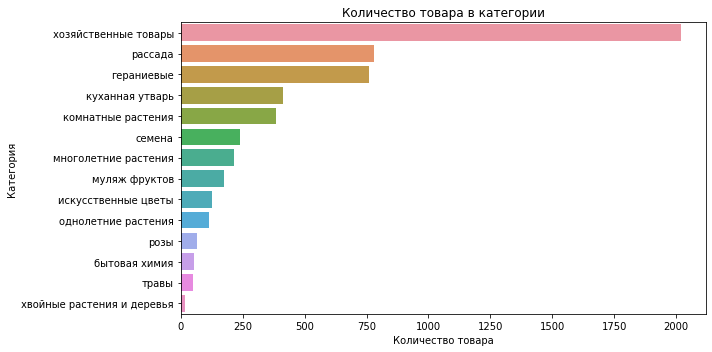

In [52]:
#построим график
plt.figure(figsize=(10,5))
sns.barplot(data=category_df, x='count',y='product_category')
plt.title('Количество товара в категории')
plt.xlabel('Количество товара')
plt.ylabel('Категория')
plt.tight_layout()

plt.show()

Получилось 14 категорий товаров. Первое место по ассортименту занимает категория xозяйственные товары, далее идет рассада и гераневые(вид цветов)

### Посмотрим топ 10 товаров, которые лучше всего продаются. 

In [53]:
# посмотрим топ 10 товаров, которые лучше всего продаются
df.groupby('product')['quantity'].sum().sort_values(ascending=False).head(10)

product
муляж яблоко 9 см красное                                                         618
вешалки мягкие для деликатных вещей 3 шт шоколад                                  335
ручка-скоба рс-100 белая *трибатрон*, 1108035                                     201
муляж яблоко зеленый 9 см полиуретан                                              188
крепеж для пружины дверной, 1107055                                               170
плечики пластмассовые размер 52 - 54 тула 1205158                                 160
пружина дверная 240 мм оцинкованная (д-19 мм) без крепления, 1107014              150
муляж банан желтый 21 см полиуретан                                               109
щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096    105
щетка для посуды *оля*, мультипласт 1807010                                       101
Name: quantity, dtype: int64

В топ 10 попали все товары, которые заказывают оптовики. Посмотрим какие товары заказывают не оптовики:

In [54]:
# посмотрим топ 10 товаров, которые лучше всего продаются у не оптовиков
df.query('~is_wholesale').groupby('product')['quantity'].sum().sort_values(ascending=False).head(10)

product
муляж яблоко зеленый 9 см полиуретан                                              138
цветок искусственный гвоздика пластиковая одиночная в ассортименте 50 см           97
щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096     90
ерш унитазный с деревянной ручкой , ваир 1712012                                   85
пеларгония розебудная red pandora укорененный черенок                              80
однолетнее растение петуния махровая в кассете 4 шт, россия                        78
пеларгония зональная диам. 12 см сиреневый полумахровый                            64
муляж красное яблоко мини полиуретан d-6 см                                        64
пеларгония зональная диам. 12 см красная махровая                                  63
пеларгония розебудная prins nikolai укорененный черенок                            63
Name: quantity, dtype: int64

Искуственные фрукты побеждают. Далее идут хозяйственные товары, в конце списка пеларгония и однолетнее растение. 

In [55]:
# посмотрим какие категории товаров лучше всего продаются
df.groupby('product_category')['quantity'].sum().sort_values(ascending=False)

product_category
xозяйственные товары          5605
муляж фруктов                 1498
куханная утварь               1177
рассада                       1155
гераниевые                     965
искусственные цветы            790
комнатные растения             607
cемена                         408
многолетние растения           290
однолетние растения            200
розы                           132
бытовая химия                  117
травы                           73
хвойные растения и деревья      18
Name: quantity, dtype: int64

Апсолютный лидер - xозяйственные товары. Далее идет муляж фруктов, куханная утварь и на 4 месте рассада

In [56]:
# посмотрим какие категории товаров лучше всего продаются у не оптовиков
df.query('~is_wholesale').groupby('product_category')['quantity'].sum().sort_values(ascending=False)

product_category
xозяйственные товары          3486
рассада                       1155
гераниевые                     954
куханная утварь                928
искусственные цветы            725
муляж фруктов                  717
комнатные растения             606
cемена                         408
многолетние растения           290
однолетние растения            200
розы                           132
бытовая химия                  117
травы                           72
хвойные растения и деревья      18
Name: quantity, dtype: int64

Хозяйственные товары все ровно лилируют. Рассада на втором месте. 

### Посмотрим среднюю цену в каждой категории товаров


In [57]:
avg_price = df.groupby('product_category')['price'].mean().reset_index()
avg_price.columns= ['category','avg_price']
avg_price = avg_price.sort_values(by='avg_price',ascending=False)
avg_price

,category,avg_price
1,xозяйственные товары,1107.669764
13,хвойные растения и деревья,661.176471
6,куханная утварь,408.439320
5,комнатные растения,249.320779
11,розы,210.522388
2,бытовая химия,181.751515
3,гераниевые,150.745510
10,рассада,117.296534
7,многолетние растения,116.752315
9,однолетние растения,89.104348


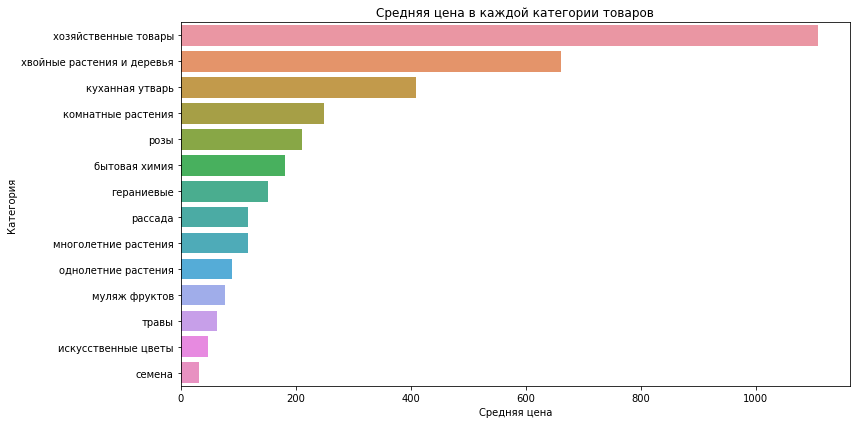

In [58]:
#построим график
plt.figure(figsize=(12,6))
sns.barplot(data=avg_price, x='avg_price',y='category')
plt.title('Средняя цена в каждой категории товаров')
plt.xlabel('Средняя цена')
plt.ylabel('Категория')
plt.tight_layout()

plt.show()

Первое место заняли xозяйственные товары. Далее c большим отставанием хвойные растения и деревья. Потом идет куханная утварь. И на 4 месте комнатные растения	

### Посмотрим на средние значения признаков в разных категориях товаров - какие категории товаров покупают больше, а какие меньке, в какой сезон эти товары лучше продаются. Построим столбчатые гистограммы и распределения признаков

In [59]:
#построим таблицу с распределением прoдаж по месяцам по категориям товаров. Возьмем данные за все года
sales_by_month_year = df.groupby(['date_new','product_category'], as_index=False)['quantity'].sum()


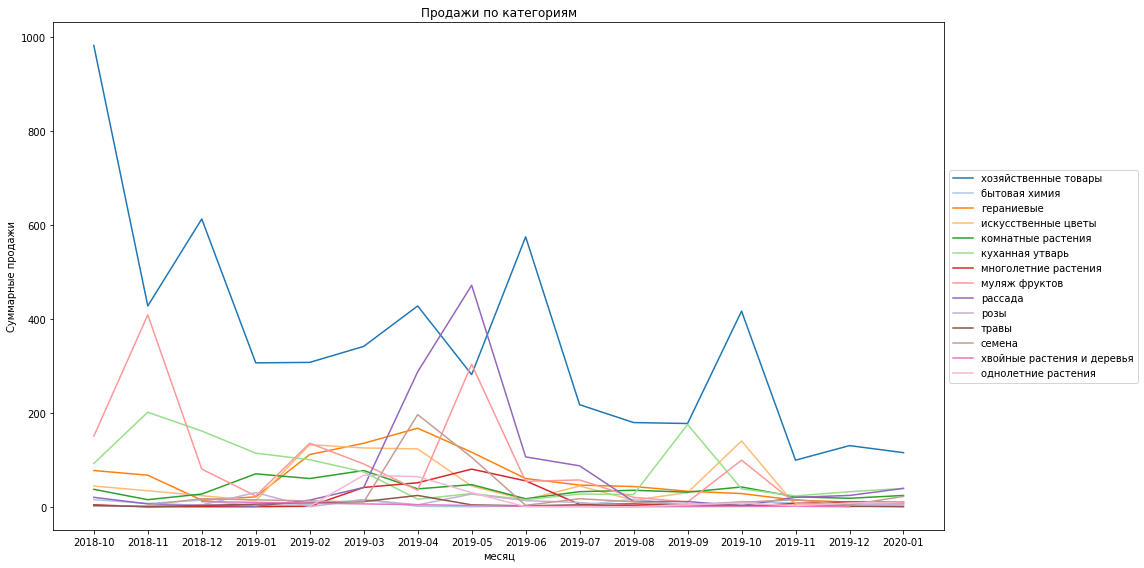

In [60]:
# добавим разные цвета для графика
palette = sns.color_palette('tab20',14)
#построим график
plt.figure(figsize=(16,8))
sns.lineplot(data=sales_by_month_year,x='date_new',y='quantity', hue='product_category', palette=palette)
plt.title('Продажи по категориям')
plt.xlabel('месяц')
plt.ylabel('Суммарные продажи')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.tight_layout()

plt.show()

По сезонности очевидный пик по покупкам с апреля по июнь. Хозяйственные товары покупают хорошо весь год, с пиками в апреле, июне и октябре. Так же был пик продаж с октября по декабрь 2018 года. Но на следующий год уже нет такого сильного пика. Рассада - очевидный пик в мае. Семена покупают в апреле. Куфанная утварь - зимой, перед новым годом и в сентябре. 

## Сегментируем покупателей по кластерам

### Сделаем агрегированные признаки для каждого покупателя:

общее количество заказов,

среднее количество товарив в заказе, 

средний чек заказа, 

средняя цена заказываемого товара.
   

In [61]:
# сначала добавим в основную таблицу столбец где мы посчитаем чек по каждому заказу
df['total_price'] = df['quantity']*df['price']

In [62]:
# сделаем таблицу по заказам
orders = df.groupby(['customer_id','order_id']).agg({'quantity':'sum',  #количество едениц в заказе
                                                    'total_price':'sum' #сумма по заказу-чек
                                                   }).reset_index()


In [63]:

# агрегируем по customer_id до нужных признаков
customers = orders.groupby('customer_id').agg({'order_id':'count',  #общее количество заказов
                                              'quantity':'mean',    #среднее количество товарив в заказе
                                              'total_price':'mean'        #средний чек заказа
                                              }).reset_index()


In [64]:
# расчитаем среднюю цену товара для каждого покупателя
avg_item_price = df.groupby('customer_id').apply(lambda x: (x['price']* x['quantity']).sum()/ x['quantity'].sum()
                                                ).reset_index()
avg_item_price.head()

,customer_id,0
0,000d6849-084e-4d9f-ac03-37174eaf60c4,138.75
1,001cee7f-0b29-4716-b202-0042213ab038,442.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,457.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,1649.00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1162.00


In [65]:
final_customers = customers.merge(avg_item_price, on='customer_id')
final_customers.head()

,customer_id,order_id,quantity,total_price,0
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,4.0,555.0,138.75
1,001cee7f-0b29-4716-b202-0042213ab038,1,1.0,442.0,442.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,2.0,914.0,457.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1.0,1649.0,1649.00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2.0,2324.0,1162.00


In [66]:
# переименуем столбцы
final_customers.columns = ['customer_id','количество заказов','среднее количество товарив в заказе','средний чек заказа','средняя цена заказываемого товара']


In [67]:
# перед стандартизацией проверим типы данных
final_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2430 entries, 0 to 2429
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          2430 non-null   object 
 1   количество заказов                   2430 non-null   int64  
 2   среднее количество товарив в заказе  2430 non-null   float64
 3   средний чек заказа                   2430 non-null   float64
 4   средняя цена заказываемого товара    2430 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 113.9+ KB


### Стандартизируем данные.

In [68]:
df_cluster = final_customers.drop(columns=['customer_id'])

In [69]:
#стандартизуруем признаки:
scaler = StandardScaler()
X_sc = scaler.fit_transform(df_cluster) 

### Нарисуем дендрограмму.

In [70]:
#построим матрицу расстояний:
linked = linkage(X_sc, method = 'ward') 

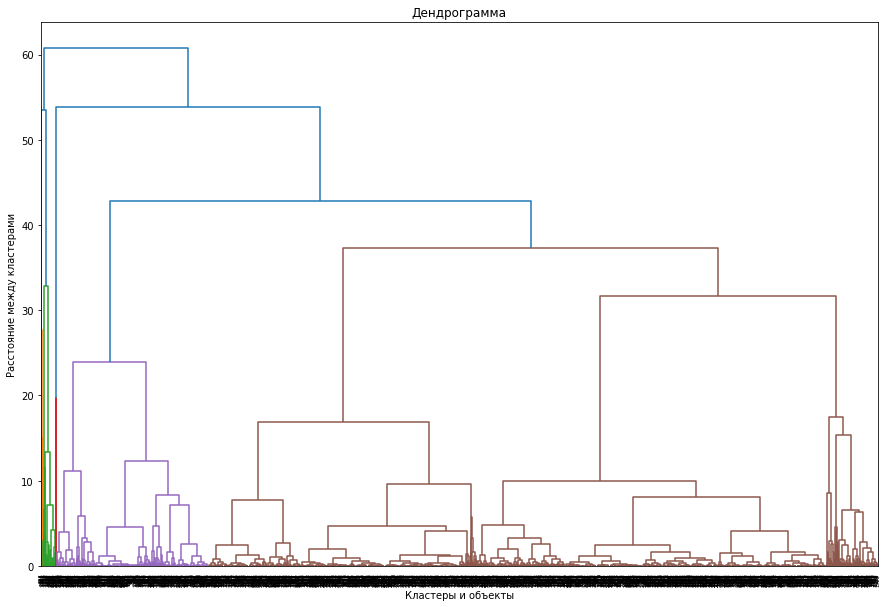

In [71]:
#визуализируем дендрограмму:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.xlabel('Кластеры и объекты')
plt.ylabel('Расстояние между кластерами')

plt.show() 

Дендрограмма показывает что лучше всего взять три кластера.

### Обучим модель кластеризации на основании алгоритма K-Means.

In [72]:
# задаём модель k_means с числом кластеров 
km = KMeans(n_clusters=3, random_state=0)
km.fit(X_sc)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels =  km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
final_customers['cluster'] = labels


In [73]:
# выводим статистику по средним значениям наших признаков по класте
cluster_means = final_customers.groupby('cluster').mean().reset_index()
cluster_means

,cluster,количество заказов,среднее количество товарив в заказе,средний чек заказа,средняя цена заказываемого товара
0,0,1.392649,4.009850,823.255181,483.657863
1,1,1.000000,194.666667,18378.888889,143.773927
2,2,1.378947,2.374123,4466.741228,3373.792440


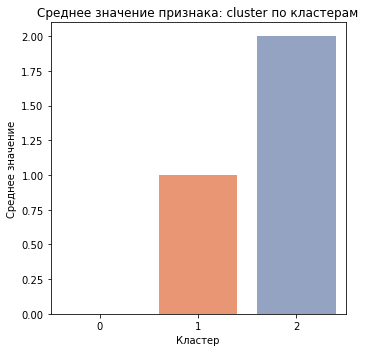

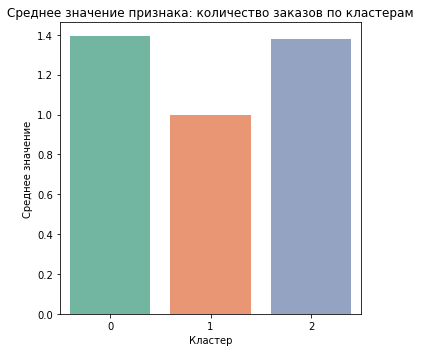

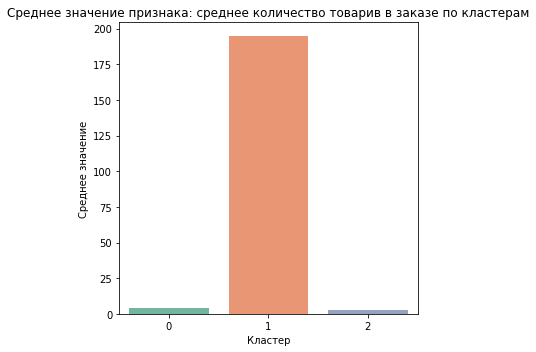

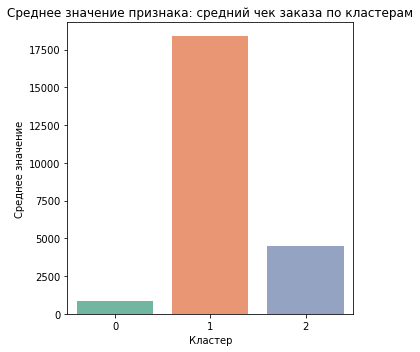

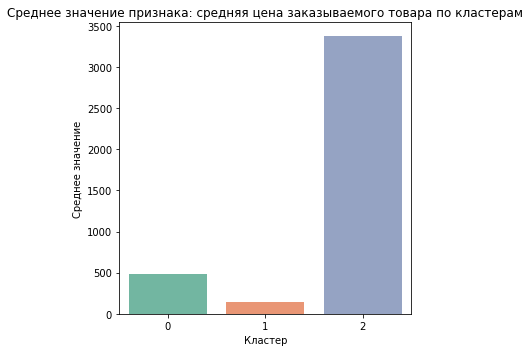

In [74]:
for col in cluster_means.columns:
    plt.figure(figsize=(5, 5))
    sns.barplot(x=cluster_means.index, y=cluster_means[col], palette='Set2')
    plt.title(f'Среднее значение признака: {col} по кластерам')
    plt.xlabel('Кластер')
    plt.ylabel('Среднее значение')
    plt.tight_layout()
    plt.show()    

Вывод: Разделили на три кластера. Видно что между кластерами есть признаки которые сильно отличаются, это 

средний чек заказа: 
у кластера 0 она самая маленькая, 
у кластера 1 самый большой средний чек, при этом средняя цена товара самая низкая, это может нам сказать о том, что делают большие заказы(оптом) но при этом очень не дорогих товаров. 

средняя цена заказываемого товара: в кластере 2 самая высокая, при этом средний чек ниже чем у кластера 1, это может говорить нам о точ, что заказывают не много но при этом дорогие товары. 


среднее количество товаро в заказе: 
самое большое у кластера 1, скорее всего оптовик

По количеству заказов кластер 0 и 2 похожи, а кластер 1 это те кто сделал всего один заказ. 


## Сформулируем и проверим статистические гипотезы

### Проверим распределение количества посетителей в группах

In [75]:
final_customers_count = final_customers.groupby('cluster')['customer_id'].count().reset_index()
final_customers_count

,cluster,customer_id
0,0,2231
1,1,9
2,2,190


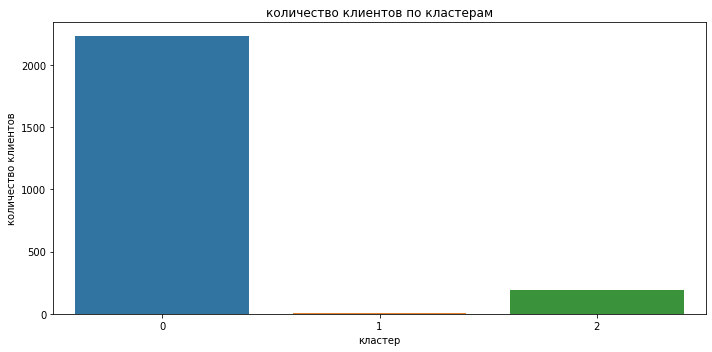

In [76]:
#построим график
plt.figure(figsize=(10,5))
sns.barplot(data=final_customers_count, x='cluster',y='customer_id')
plt.title('количество клиентов по кластерам')
plt.xlabel('кластер')
plt.ylabel('количество клиентов')
plt.tight_layout()

plt.show()

Предположим что распределение по кластерам такое:

    0 - обычные покупатели
    
    1 - оптовики
    
    2 - с высоким средним чеком


### Посмотрим есть ли разница в среднем чеке заказа между группами. H0 - нет различий между кластерами, H1 - различия между кластерами есть.  

In [77]:
# перед тем как делать t-test проверим данные на нормальность

for i in final_customers['cluster'].unique():
    print(f'Кластер {i}:')
    stat, p = shapiro(final_customers[final_customers['cluster'] == i]['средний чек заказа'])
    print(f'p-value: {p}')

Кластер 0:
p-value: 0.0
Кластер 2:
p-value: 3.610413152627386e-21
Кластер 1:
p-value: 0.04939040541648865


Мы видим что р < 0.05, что значит распределение не нормальное. 

Используем тест mannwhitneyu, он не требует нормальности и более устойчив к разным размерам выборок. Для того чтобы избежать ошибки первого  рода, используем метод Бонферрони, он достаточно простой и хороши поджодит для сревнения трех гипотез. 

In [78]:
# выборки
group_0 = final_customers[final_customers['cluster'] == 0]['средний чек заказа']
group_1 = final_customers[final_customers['cluster'] == 1]['средний чек заказа']
group_2 = final_customers[final_customers['cluster'] == 2]['средний чек заказа']

# Количество сревнений: 3 - Бонферрони: умножаем p_value на 3
comparisons = [
    ("0 vs 1", group_0, group_1),
    ("0 vs 2", group_0, group_2),
    ("1 vs 2", group_1, group_2),
]

# Проверка
for name, g1, g2 in comparisons:
    stat, p = mannwhitneyu(g1, g2, alternative='two-sided')
    corrected_p = min(p * 3, 1.0)  # Бонферрони
    print(f"{name}: raw p = {p:.5f}, Bonferroni corrected p = {corrected_p:.5f}")

0 vs 1: raw p = 0.00000, Bonferroni corrected p = 0.00000
0 vs 2: raw p = 0.00000, Bonferroni corrected p = 0.00000
1 vs 2: raw p = 0.00010, Bonferroni corrected p = 0.00029


In [79]:
# Пары кластеров
clusters = final_customers['cluster'].unique()
pairs = list(combinations(clusters, 2))

alpha = 0.05
num_tests = len(pairs)
corrected_alpha = alpha / num_tests  # Бонферрони-коррекция
print(f"Скорректированный уровень значимости (Bonferroni): {corrected_alpha:.4f}\n")

# Результаты теста Манна-Уитна с коррекцией
for c1, c2 in pairs:
    group1 = final_customers[final_customers['cluster'] == c1]['средний чек заказа']
    group2 = final_customers[final_customers['cluster'] == c2]['средний чек заказа']
 
    
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    print(f"Сравнение кластеров {c1} vs {c2}: p-value = {p:.4f}")
    if p < corrected_alpha:
        print(f"Отвергаем Н0: Есть статистически значимое различие кластеров {c1} vs {c2}")
    else:
        print(f"НЕ отвергаем Н0:Нет статистически значимого различия кластеров {c1} vs {c2}")

Скорректированный уровень значимости (Bonferroni): 0.0167

Сравнение кластеров 0 vs 2: p-value = 0.0000
Отвергаем Н0: Есть статистически значимое различие кластеров 0 vs 2
Сравнение кластеров 0 vs 1: p-value = 0.0000
Отвергаем Н0: Есть статистически значимое различие кластеров 0 vs 1
Сравнение кластеров 2 vs 1: p-value = 0.0001
Отвергаем Н0: Есть статистически значимое различие кластеров 2 vs 1


Провели тест Манна-Уитни для сравнения кластеров 0, 1 и 2 по среднему чеку заказа. Результат p-value = 0.000000, 0.00010 , что позволяет отклонить Н0 и сделать вывод о существенных различиях между группами

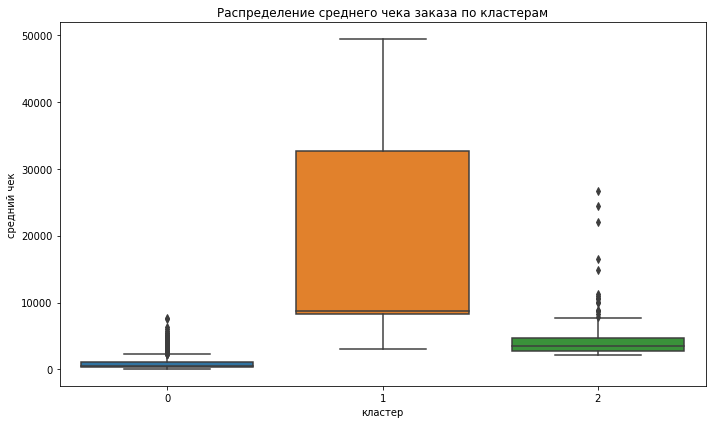

In [80]:
# визуализируем распределение количество заказов по кластерам.
# построим график ящик с усами
plt.figure(figsize=(10,6))
sns.boxplot(x='cluster', y='средний чек заказа', data=final_customers)
plt.title('Распределение среднего чека заказа по кластерам')
plt.xlabel('кластер')
plt.ylabel('средний чек')
plt.tight_layout()

plt.show()

График ящик с усами по среднему чеку заказа показвает, что кластер 1 отличается существенно более высоким средним чеком. Видно что ящики практически не перекрываются друг с другом. Это подтверждает что по метрике средний чек кластеры разделены качественно.

Вывод: Средний чек статистически значимо отличается между всеми триемя кластерами, это значит что кластеры сигментируют пользователей по уровню затрат на заказ и это полезно для маркетинга и для акций. То есть кластеризация действительно выявила разные сегменты. 

### Посмотрим есть ли разница в общем количестве заказов на посетителя.H0 - нет различий между общем количестве заказов, H1 - различия между общем количестве заказов есть.

In [81]:
# перед тем как делать t-test проверим данные на нормальность

for i in final_customers['cluster'].unique():
    print(f'Кластер {i}:')
    stat, p = shapiro(final_customers[final_customers['cluster'] == i]['количество заказов'])
    print(f'p-value: {p}')

Кластер 0:
p-value: 0.0
Кластер 2:
p-value: 7.010818395542056e-20
Кластер 1:
p-value: 1.0


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


В наших данных только кластер 1 имеет нормальное распределение. Кластер 0 и 2 имеют ненормальное распределение. Используем так же тест mannwhitneyu

In [82]:
# Пары кластеров
clusters = final_customers['cluster'].unique()
pairs = list(combinations(clusters, 2))

alpha = 0.05
num_tests = len(pairs)
corrected_alpha = alpha / num_tests  # Бонферрони-коррекция
print(f"Скорректированный уровень значимости (Bonferroni): {corrected_alpha:.4f}\n")

# Результаты теста Манна-Уитна с коррекцией
for c1, c2 in pairs:
    group1 = final_customers[final_customers['cluster'] == c1]['количество заказов']
    group2 = final_customers[final_customers['cluster'] == c2]['количество заказов']
 
    
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    print(f"Сравнение кластеров {c1} vs {c2}: p-value = {p:.4f}")
    if p < corrected_alpha:
        print(f"Отвергаем Н0: Есть статистически значимое различие кластеров {c1} vs {c2}")
    else:
        print(f"НЕ отвергаем Н0:Нет статистически значимого различия кластеров {c1} vs {c2}")

Скорректированный уровень значимости (Bonferroni): 0.0167

Сравнение кластеров 0 vs 2: p-value = 0.9684
НЕ отвергаем Н0:Нет статистически значимого различия кластеров 0 vs 2
Сравнение кластеров 0 vs 1: p-value = 0.0255
НЕ отвергаем Н0:Нет статистически значимого различия кластеров 0 vs 1
Сравнение кластеров 2 vs 1: p-value = 0.0282
НЕ отвергаем Н0:Нет статистически значимого различия кластеров 2 vs 1


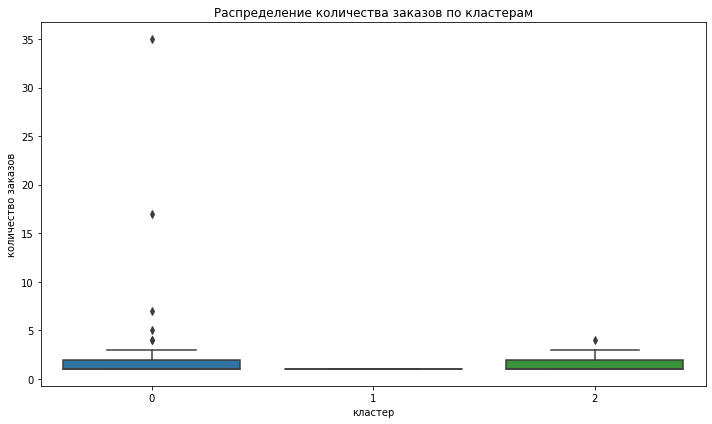

In [83]:
# визуализируем распределение количество заказов по кластерам.
# построим график ящик с усами
plt.figure(figsize=(10,6))
sns.boxplot(x='cluster', y='количество заказов', data=final_customers)
plt.title('Распределение количества заказов по кластерам')
plt.xlabel('кластер')
plt.ylabel('количество заказов')
plt.tight_layout()

plt.show()

Мы видим что по этой метрики поведения клиентов схоже. Все три ящика находятся примерно на одном уровне. Есть единичные выбросы, но они редкие. 

Вывод: Различия по количеству заказов нет, но это не делает кластеризацию неуспешной. Это может говорить нам о том, что по этой метрике поведения клиентов схожи. Ранее было выявлено небольшое количество клиентов которые совершили более 2 заказов, всего 26 клиентов, именно поэтому эта метрика не так видна. 

### Посмотрим есть ли разница в средней цене заказываемого товара на посетителя.H0 - нет различий между средней ценой , H1 - различия между средней ценой  есть.

In [84]:
# перед тем как делать t-test проверим данные на нормальность

for i in final_customers['cluster'].unique():
    print(f'Кластер {i}:')
    stat, p = shapiro(final_customers[final_customers['cluster'] == i]['средняя цена заказываемого товара'])
    print(f'p-value: {p}')

Кластер 0:
p-value: 5.885453550164232e-44
Кластер 2:
p-value: 1.4956127157052246e-13
Кластер 1:
p-value: 0.0015336823416873813


Мы видим что р < 0.05, что значит распределение не нормальное. 

In [85]:
# Пары кластеров
clusters = final_customers['cluster'].unique()
pairs = list(combinations(clusters, 2))

alpha = 0.05
num_tests = len(pairs)
corrected_alpha = alpha / num_tests  # Бонферрони-коррекция
print(f"Скорректированный уровень значимости (Bonferroni): {corrected_alpha:.4f}\n")

# Результаты теста Манна-Уитна с коррекцией
for c1, c2 in pairs:
    group1 = final_customers[final_customers['cluster'] == c1]['средняя цена заказываемого товара']
    group2 = final_customers[final_customers['cluster'] == c2]['средняя цена заказываемого товара']
 
    
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    print(f"Сравнение кластеров {c1} vs {c2}: p-value = {p:.4f}")
    if p < corrected_alpha:
        print(f"Отвергаем Н0: Есть статистически значимое различие кластеров {c1} vs {c2}")
    else:
        print(f"НЕ отвергаем Н0:Нет статистически значимого различия кластеров {c1} vs {c2}")

Скорректированный уровень значимости (Bonferroni): 0.0167

Сравнение кластеров 0 vs 2: p-value = 0.0000
Отвергаем Н0: Есть статистически значимое различие кластеров 0 vs 2
Сравнение кластеров 0 vs 1: p-value = 0.0022
Отвергаем Н0: Есть статистически значимое различие кластеров 0 vs 1
Сравнение кластеров 2 vs 1: p-value = 0.0000
Отвергаем Н0: Есть статистически значимое различие кластеров 2 vs 1


Провели тест Манна-Уитни для сравнения кластеров 0, 1 и 2 по средней цене заказываемого товара. Результат p-value = 0.000000, 0.00022 , что позволяет отклонить Н0 и сделать вывод о существенных различиях между группами

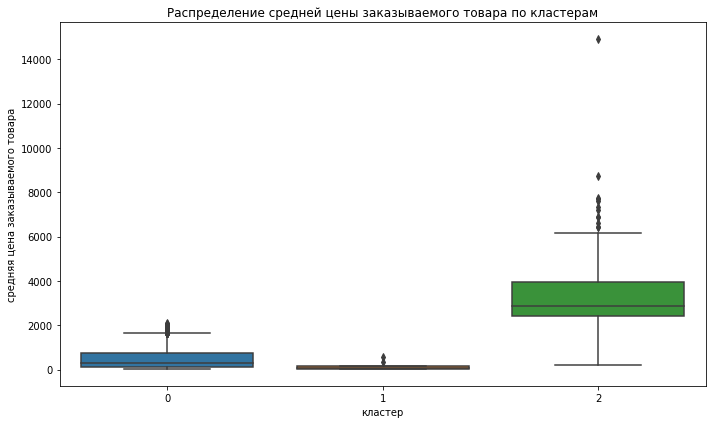

In [86]:
# визуализируем распределение средняя цена заказываемого товара по кластерам.
# построим график ящик с усами
plt.figure(figsize=(10,6))
sns.boxplot(x='cluster', y='средняя цена заказываемого товара', data=final_customers)
plt.title('Распределение средней цены заказываемого товара по кластерам')
plt.xlabel('кластер')
plt.ylabel('средняя цена заказываемого товара')
plt.tight_layout()

plt.show()

График ящик с усами по средней цены заказываемого товара показвает, что кластер 2 отличается существенно более высокой ценой за товар. Видно что ящик 2 практически не перекрываются с другими ящиками. Это подтверждает что по метрике средней цены заказываемого товара кластеры разделены качественно.

Вывод: Средняя цена заказываемого товара статистически значимо отличается между всеми триемя кластерами, это значит что кластеры сигментируют пользователей цене, которую они готовы потратить на еденицу товара. Это полезно для маркетинга и для акций. То есть кластеризация действительно выявила разные сегменты. 

## Распределение признаков по сегментам

__Посмотрим на средние значения признаков (сезонность и категория товара) для кластеров. И построим распределения признаков для кластеров на графиках.__
    

In [87]:
# объеденим основную таблицу с таблицей с кластелрами
df_merge = df.merge(final_customers[['customer_id','cluster']], on='customer_id', how='left')
df_merge.head()

,date,customer_id,order_id,product,quantity,price,date_new,total_price,is_wholesale,top_clients,product_category,cluster
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10,142.0,False,False,комнатные растения,0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10,194.0,False,False,куханная утварь,0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10,112.0,False,False,комнатные растения,0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10,179.0,False,False,комнатные растения,0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10,112.0,False,False,комнатные растения,0


### Признак сезонность

In [88]:
# посмотрим таблицу по количеству проданных товаров по кластерам 
group_month_cluster = df_merge.groupby(['date_new','cluster'])['quantity'].sum().reset_index()

group_month_cluster.head()

,date_new,cluster,quantity
0,2018-10,0,1072
1,2018-10,1,300
2,2018-10,2,63
3,2018-11,0,697
4,2018-11,1,411


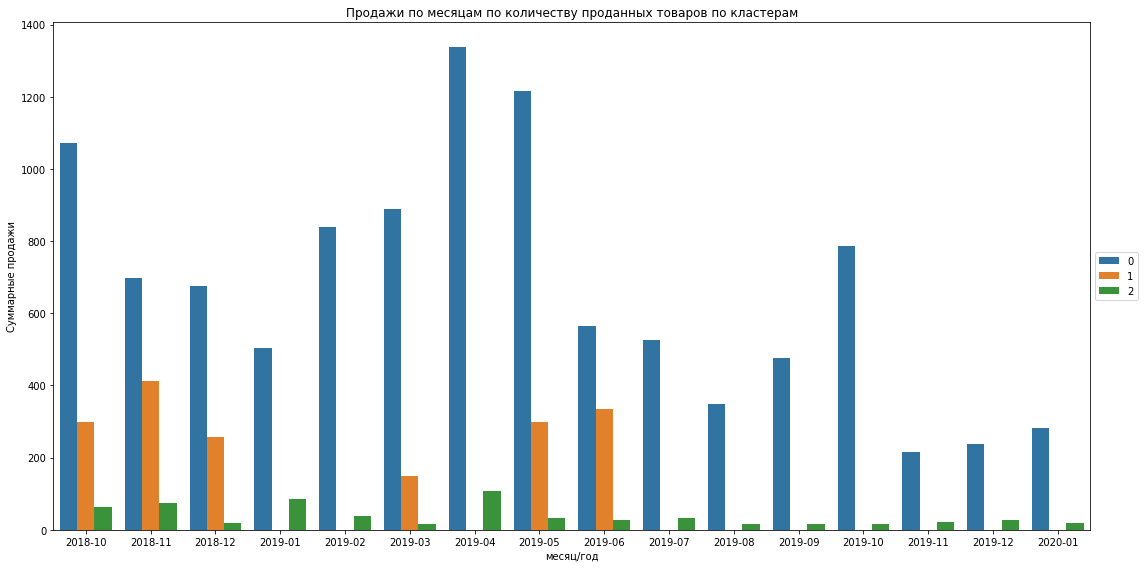

In [89]:
#построим график
plt.figure(figsize=(16,8))
sns.barplot(data=group_month_cluster,x='date_new',y='quantity', hue='cluster')
plt.title('Продажи по месяцам по количеству проданных товаров по кластерам')
plt.xlabel('месяц/год')
plt.ylabel('Суммарные продажи')

plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.tight_layout()

plt.show()

Так как у нас очень разные группы по количеству клиентов, первая группа будет иметь приемущества в каждом месяце. Рассмотрим еще отдельно каждый кластер:

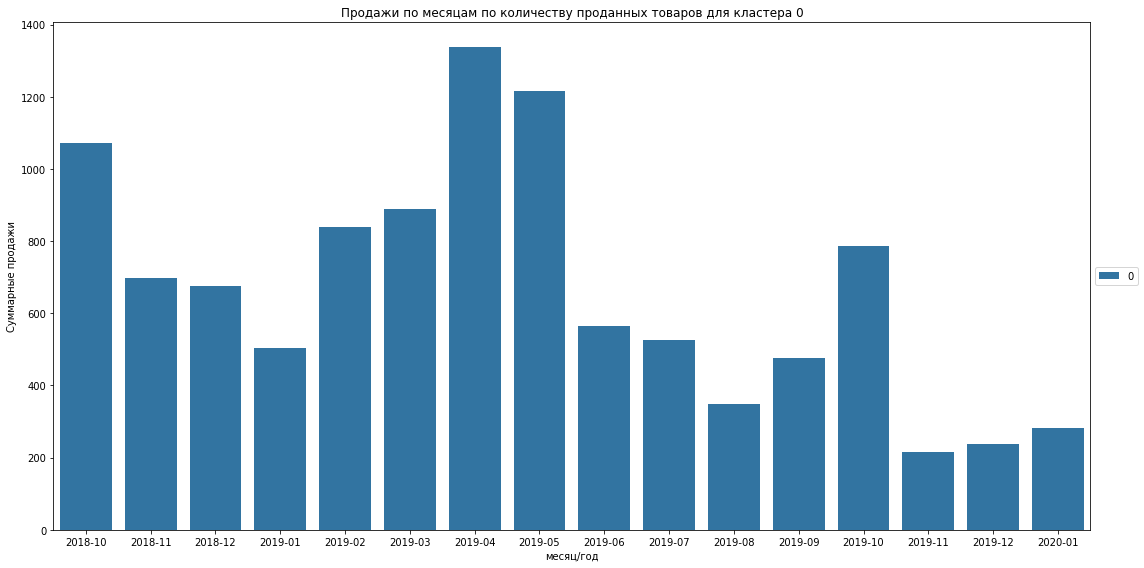

In [90]:
#построим график
plt.figure(figsize=(16,8))
sns.barplot(data=group_month_cluster.query('cluster == 0'),x='date_new',y='quantity', hue='cluster')
plt.title('Продажи по месяцам по количеству проданных товаров для кластера 0')
plt.xlabel('месяц/год')
plt.ylabel('Суммарные продажи')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.tight_layout()

plt.show()

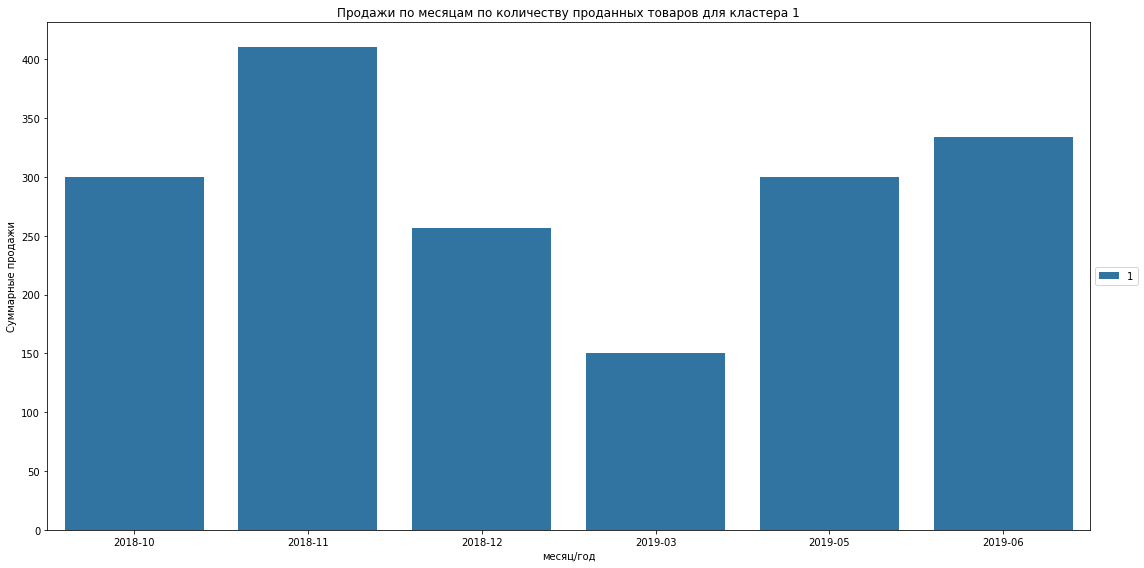

In [91]:
#построим график
plt.figure(figsize=(16,8))
sns.barplot(data=group_month_cluster.query('cluster == 1'),x='date_new',y='quantity', hue='cluster')
plt.title('Продажи по месяцам по количеству проданных товаров для кластера 1')
plt.xlabel('месяц/год')
plt.ylabel('Суммарные продажи')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.tight_layout()

plt.show()

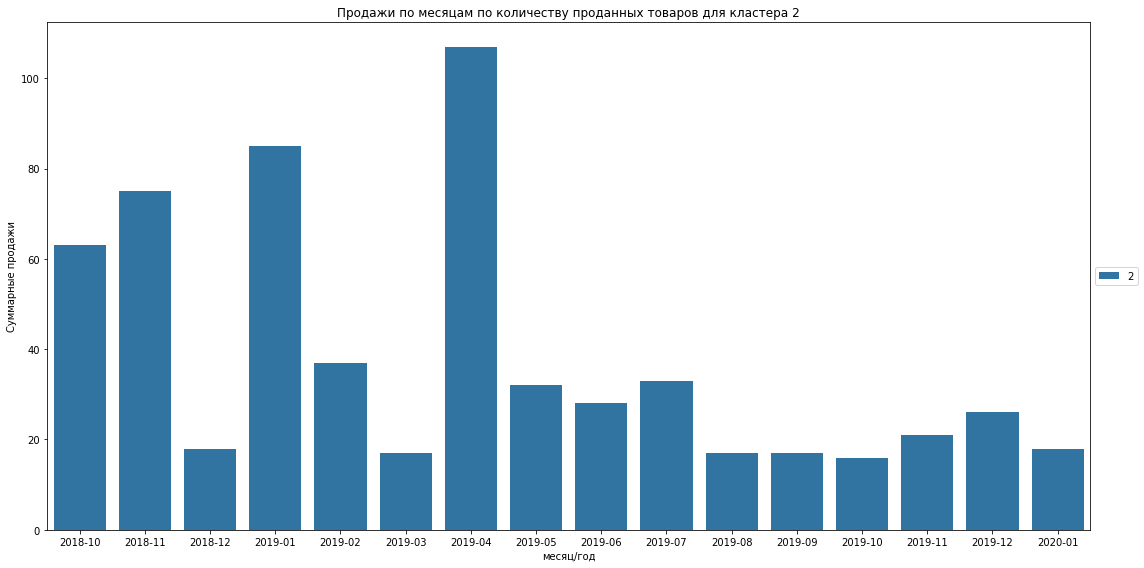

In [92]:
#построим график
plt.figure(figsize=(16,8))
sns.barplot(data=group_month_cluster.query('cluster == 2'),x='date_new',y='quantity', hue='cluster')
plt.title('Продажи по месяцам по количеству проданных товаров для кластера 2')
plt.xlabel('месяц/год')
plt.ylabel('Суммарные продажи')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.tight_layout()

plt.show()

На графиках по кластерам видно, что: 

0 группа, самая большая по численности, основной пик заказов апрель, май, так же высокий месяц октябрь.

1 группа - делает заказы перед новым годом, в 10, 11 и 12 месяцах. Так же делала заказы в марте,  мае и июне. 

2 группа - апрель пик заказов. Так же большое количество заказов было в октябре,ноябре 2018 и в январе 2019. А в конце следующего года в это же время уже не было такого количества заказов. 
 

In [93]:
# посмотрим таблицу по суммарным продажам по кластерам по месяцам
group_month_cluster_total_price = df_merge.groupby(['date_new','cluster'])['total_price'].sum().reset_index()

group_month_cluster_total_price.head()

,date_new,cluster,total_price
0,2018-10,0,247324.0
1,2018-10,1,8550.0
2,2018-10,2,67423.0
3,2018-11,0,177122.0
4,2018-11,1,50610.0


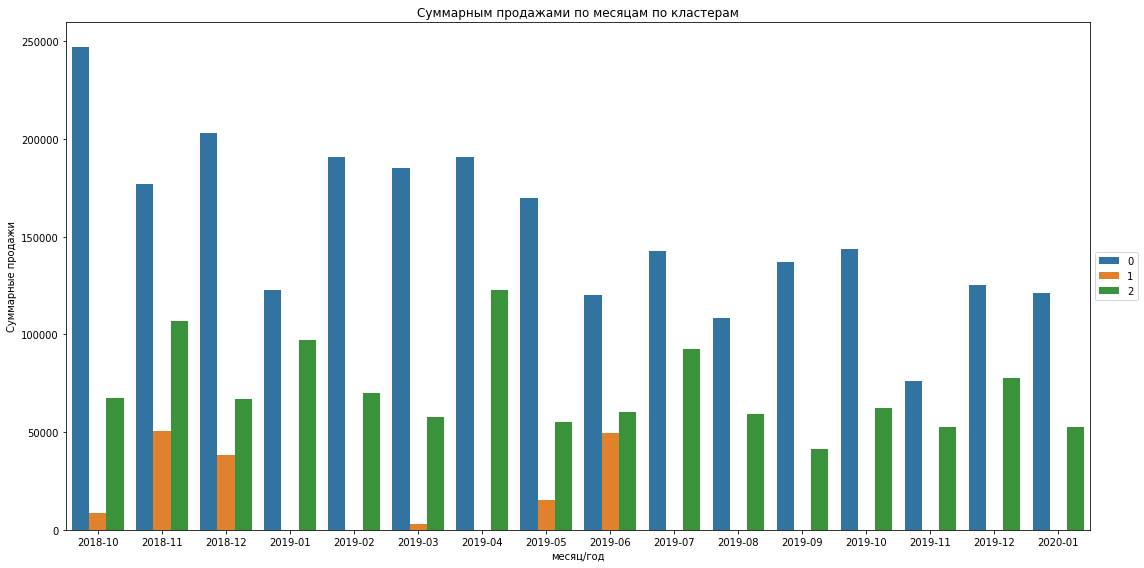

In [94]:
#построим график
plt.figure(figsize=(16,8))
sns.barplot(data=group_month_cluster_total_price,x='date_new',y='total_price', hue='cluster')
plt.title('Cуммарным продажами по месяцам по кластерам')
plt.xlabel('месяц/год')
plt.ylabel('Суммарные продажи')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.tight_layout()

plt.show()

Если рассматривать суммарные продажи, то мы увидем, что кластер 2 значительно вырос по сравнению с графиком, где показаны количественные продажи. Что говорит нам о том, что клиенты из кластера 2 покупают более дорогие товары.  

### Признак категория товара

In [95]:
group_product_category_cluster_1 =df_merge.pivot_table(index='product_category',
                                                columns='cluster',
                                                values='quantity', 
                                                aggfunc='sum').reset_index()

group_product_category_cluster_1=group_product_category_cluster_1.fillna(0)

group_product_category_cluster_1

cluster,product_category,0,1,2
0,cемена,407.0,0.0,1.0
1,xозяйственные товары,4035.0,1041.0,529.0
2,бытовая химия,116.0,0.0,1.0
3,гераниевые,965.0,0.0,0.0
4,искусственные цветы,790.0,0.0,0.0
5,комнатные растения,553.0,0.0,54.0
6,куханная утварь,1060.0,101.0,16.0
7,многолетние растения,287.0,0.0,3.0
8,муляж фруктов,888.0,610.0,0.0
9,однолетние растения,200.0,0.0,0.0


In [96]:
#  Суммарные продажи по категориям (по всем кластерам)
group_product_category_cluster_1['total'] = group_product_category_cluster_1[[0,1,2]].sum(axis=1)
group_product_category_cluster_1

cluster,product_category,0,1,2,total
0,cемена,407.0,0.0,1.0,408.0
1,xозяйственные товары,4035.0,1041.0,529.0,5605.0
2,бытовая химия,116.0,0.0,1.0,117.0
3,гераниевые,965.0,0.0,0.0,965.0
4,искусственные цветы,790.0,0.0,0.0,790.0
5,комнатные растения,553.0,0.0,54.0,607.0
6,куханная утварь,1060.0,101.0,16.0,1177.0
7,многолетние растения,287.0,0.0,3.0,290.0
8,муляж фруктов,888.0,610.0,0.0,1498.0
9,однолетние растения,200.0,0.0,0.0,200.0


In [97]:
# Устанавливаем порог (например, < 200 во всех кластерах суммарно)
threshold = 200
small_categories = group_product_category_cluster_1[group_product_category_cluster_1['total'] < threshold]
large_categories = group_product_category_cluster_1[group_product_category_cluster_1['total'] >= threshold]

In [98]:
# Суммируем мелкие категории по кластерам
others_row = small_categories[[0, 1, 2]].sum().to_frame().T
others_row['product_category'] = 'Другие'

In [99]:
# Собираем всё обратно
result = pd.concat([large_categories.drop(columns='total'), others_row], ignore_index=True)

result

cluster,product_category,0,1,2
0,cемена,407.0,0.0,1.0
1,xозяйственные товары,4035.0,1041.0,529.0
2,гераниевые,965.0,0.0,0.0
3,искусственные цветы,790.0,0.0,0.0
4,комнатные растения,553.0,0.0,54.0
5,куханная утварь,1060.0,101.0,16.0
6,многолетние растения,287.0,0.0,3.0
7,муляж фруктов,888.0,610.0,0.0
8,однолетние растения,200.0,0.0,0.0
9,рассада,1150.0,0.0,5.0


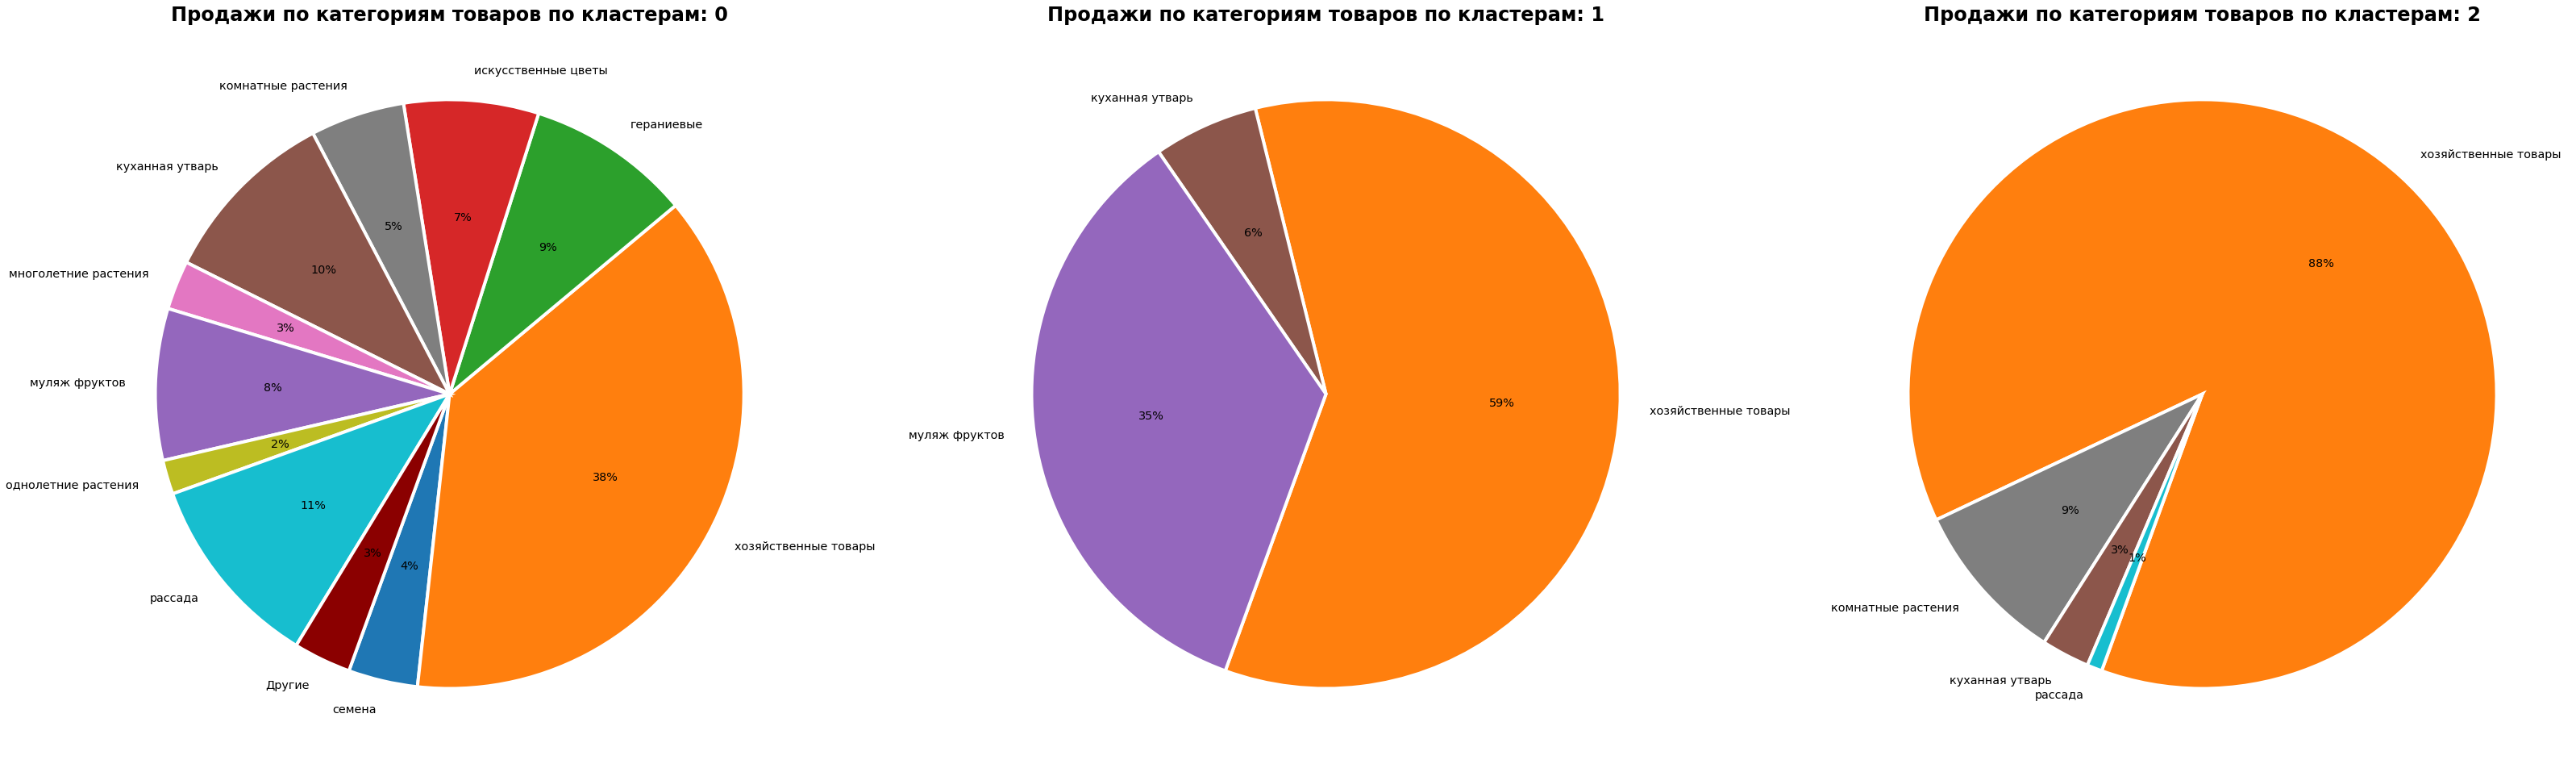

In [100]:
# Каждый кластер визуализируем отдельно
  
clasters = [0,1,2]
titles = ['0', '1', '2']

# Создаём подграфики (1 ряд, 3 колонки)
fig, axes = plt.subplots(1, 3, figsize=(45,15))

for i, claster in enumerate(clasters):
    data = result[claster]
    
    mask = data>3
    values = data[mask]
    labels = result['product_category'][mask]
    colours = {'cемена':'C60', 'xозяйственные товары':'C1', 'гераниевые':'C2', 'искусственные цветы':'C3', 
               'комнатные растения':'C7', 'куханная утварь':'C5', 'многолетние растения':'C6', 
               'муляж фруктов':'C4', 'однолетние растения':'C8',
               'PS4':'lightsteelblue', '3DS':'orange', 
               'рассада':'C19', 'Другие':'darkred'}
    axes[i].pie(values, 
                labels=labels, 
                autopct='%1.0f%%', 
                wedgeprops={'linewidth': 4.0, 'edgecolor': 'white'}, 
                textprops={'size': 'x-large'},
                colors=[colours[key] for key in labels],
                startangle=250)
    axes[i].set_title(f'Продажи по категориям товаров по кластерам: {titles[i]}', fontsize = 24, fontweight='bold')

plt.tight_layout()
plt.show()

Хозяйственные товары абсолютные лидеры во всех кластерах. Посмотрим отдельно по кластерач какие товары заказывают:

In [101]:
group_product_category_cluster = df_merge.groupby(['date_new','product_category','cluster'])['quantity'].sum().reset_index()
group_product_category_cluster.head()

,date_new,product_category,cluster,quantity
0,2018-10,xозяйственные товары,0,622
1,2018-10,xозяйственные товары,1,300
2,2018-10,xозяйственные товары,2,60
3,2018-10,бытовая химия,0,16
4,2018-10,гераниевые,0,78


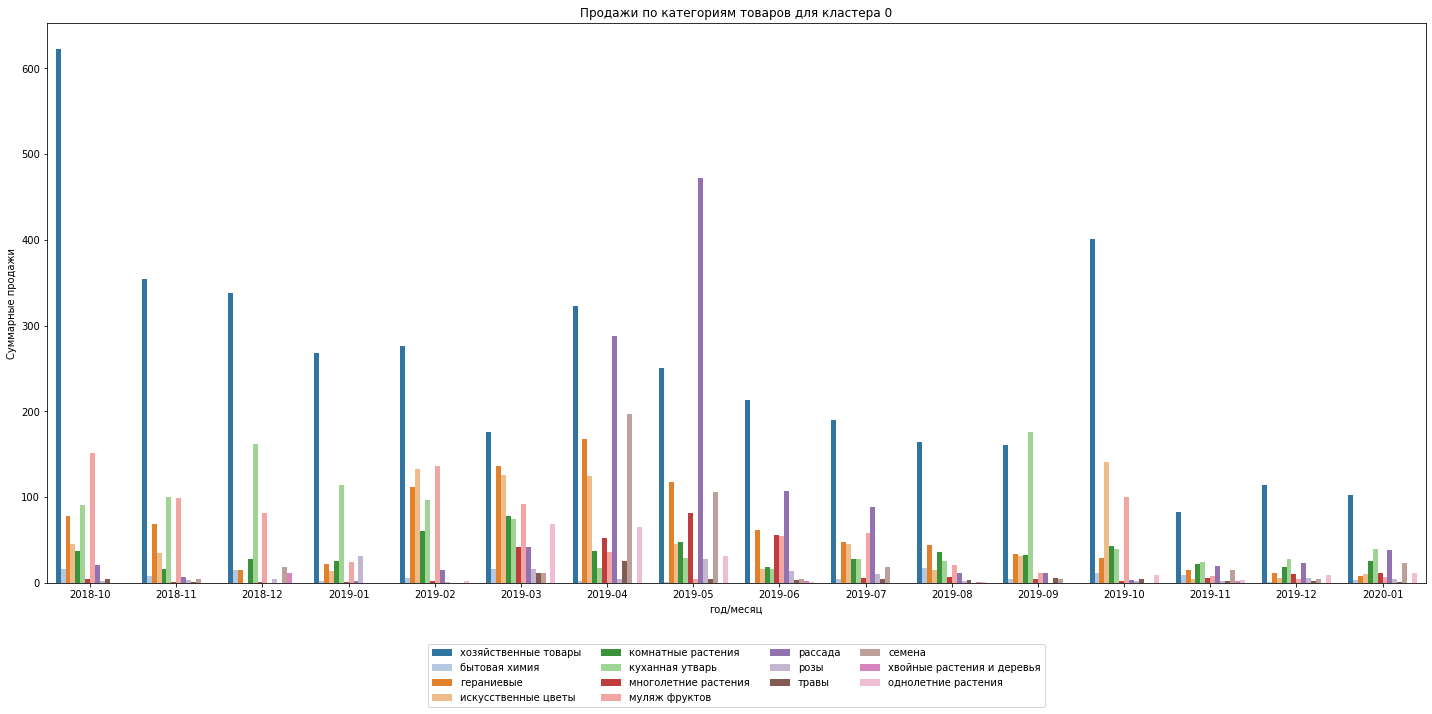

In [102]:
# добавим разные цвета для графика
palette = sns.color_palette('tab20',14)
#построим график
plt.figure(figsize=(20,10))
sns.barplot(data=group_product_category_cluster.query('cluster == 0'),
            x='date_new',
            y='quantity', 
            hue='product_category',
            palette=palette)
plt.title('Продажи по категориям товаров для кластера 0')
plt.xlabel('год/месяц')
plt.ylabel('Суммарные продажи')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1),ncol=4)
plt.tight_layout()
#plt.xticks(rotation=90)
plt.show()

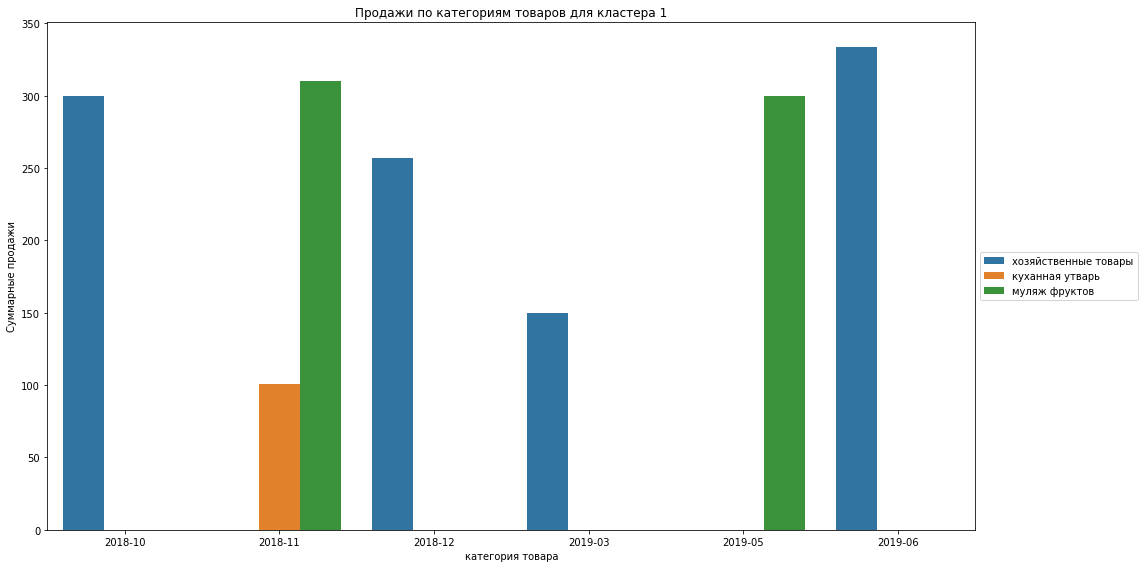

In [103]:
#построим график
plt.figure(figsize=(16,8))
sns.barplot(data=group_product_category_cluster.query('cluster == 1'),
            x='date_new',y='quantity', hue='product_category')
plt.title('Продажи по категориям товаров для кластера 1')
plt.xlabel('категория товара')
plt.ylabel('Суммарные продажи')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.tight_layout()

plt.show()

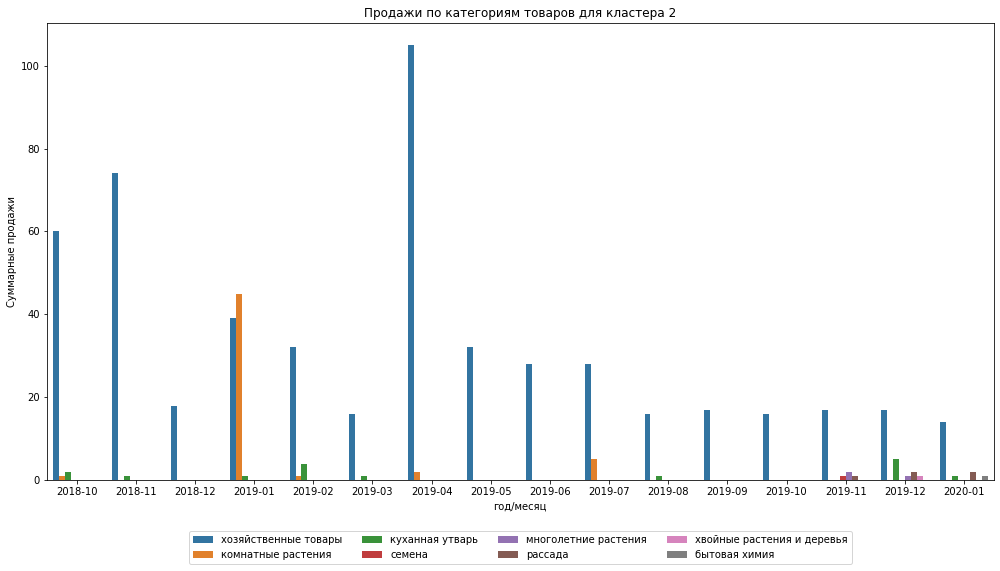

In [104]:
#построим график
plt.figure(figsize=(14,8))
sns.barplot(data=group_product_category_cluster.query('cluster == 2'),x='date_new',y='quantity', hue='product_category')
plt.title('Продажи по категориям товаров для кластера 2')
plt.xlabel('год/месяц')
plt.ylabel('Суммарные продажи')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1),ncol=4)
plt.tight_layout()

plt.show()

На графиках по кластерам видно, что: 

0 группа, самая большая по численности, заказывают все категории товаров, хоз товары абсолютный лидер.

1 группа - заказывали только хоз товары, куханную утварь и муляж фруктов. 

2 группа - заказывали в основном хоз товары, и немного из категорий: семена, бытовая химия, комнатные растения, куханная утварь, многолетние растения, рассада, хвойные растения. 

## Выводы и  базовые рекомендации по работе с клиентами

__Цель проекта:__

Сегментировать покупателей интернет-магазина товаров для дома и быта на основе потребительского поведения для запуска целевых рекламных рассылок.


__Основная информация:__
  - В исследовании использовались 7474 записи и 6 признаков, охватывающие период:
1 октября 2018 — 31 января 2020 года.
  - После предобработки (удаления дубликатов и выбросов) осталось 5556 строк.


__Основные этапы анализа:__
    
  - Удалены дубликаты, аномальные заказы и подозрительные активности (например, клиенты с экстремальным количеством покупок).
  
  
  Анализ товаров и покупателей:
  
  
  - 27 клиентов-оптовиков
  
  - 26 клиентов, заказывавших более двух товаров за раз
   
  - Большинство товаров стоит до 500 рублей.
  
  - Большинство клиентов совершили один заказ.
  
  - Товары сгруппированы по 14 категориям
  
  - Лидеры по количеству: хозяйственные товары, затем рассада и гераниевые растения.
  
  
  
 Средняя цена по категориям:
  
  - Хозяйственные товары — 1 100 руб.
  - Хвойные растения и деревья — 661 руб.
  - Кухонная утварь — 408 руб.
  - Комнатные растения — 250 руб.
  - Рассада — 117 руб.
    
    
 Сезонные пики продаж:
 
  - Март - комнатные растения
  
  - Апрель–май — рассада и семена, гераневые растения
  
  - Октябрь, декабрь и январь — хозяйственные и подарочные товары
  
  - Июнь — сезон летней бытовой продукции


__Кластеризация клиентов:__

Для кластеризации были рассчитаны индивидуальные признаки:

  - Общее количество заказов
  - Среднее количество товаров в заказе
  - Средний чек заказа
  - Средняя цена одного товара
  

__Результаты кластеризации и рекомендации по маркетинговым рассылкам:__  
  


   Проверили результаты кластеризации с помощью статистических гипотез, выяснили что кластеры сильно отличаются по метрикам средний чек заказа и средняя цена одного товара. По метрике общее количество заказов разницы в кластерах не выявили. 




   __Кластер 0__ 
  
    - 2231 клиент - обычные покупатели с низким средним чеком заказа. 
  
    - Самое большое количество заказов в октябре, апреле и мае. 
  
    - Покупают в основном хозяйственные товары, пик продаж приходится на октябрь, но так же присутствуют и все остальные категории: семена и рассаду в апереле-мае, гераневые растения с феврала по май, куханная утвар - сентябрь и декабрь.   
  
    Рекомендации:
  
   Регулярные рассылки с акциями и скидками на бытовые и садовые товары. 
  
   Период активной рассылки: март, апрель - на рассаду, растеня и семена. 
   сентябрь, октябрь- бытовые товары и куханная утварь. 
  
  
   __Кластер 1__ 
  
    - 9 клиентов, оптовики, делают дешёвые но объемные заказы, за счет чего имеют самый большой средний чек. 
  
    - Заказывают в октябре, ноябре, декабре и в мае, июне
  
    - По категориям -  бытовые товары, муляжи фруктов и кухонные товары.
  
     Рекомендации:
  
   Персональные письма с оптовыми предложениями, прайс-листами. Период: октябрь, ноябрь, март, апрель
  
  
   __Кластер 2__
  
    - 190 клиентов, покупают более дорогие товары, не оптовые закупки.
  
    - Пик покупок октябрь, ноябрь, январь и апрель. 
  
  Покупают в основном хозяйственные товары, но есть и остальные категории в небольшом количестве: комнатные растения, куханная утварь.
  
    Рекомендации:
  
  Рекламные кампании на премиальные товары с выделением качества. Период: март, апрель, октябрь, ноябрь. 
  

__Сегментация клиентов выполнена успешно. Кластеры различаются по ключевым поведенческим метрикам, особенно по ценовой чувствительности и типам покупок. Предложенные подходы к рассылкам учитывают сезонность, поведение и платежеспособность клиентов. Это позволит повысить эффективность маркетинга, сделать коммуникации персонализированными и увеличить отклик на рассылки.__